In [1]:
!python -m pip install numpy matplotlib seaborn tensorflow scikit-learn visualkeras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import normalize

sns.set_theme(style="dark") 
sns.set_palette('Set2')

2024-12-27 13:32:52.655313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735327972.686933   15780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735327972.697081   15780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 13:32:52.767464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
compound_library = {
    "methane": {
        "peak_positions": np.array([2917]),
        "peak_intensities": np.array([1.0])
    },
    "ethane": {
        "peak_positions": np.array([995, 1460, 2880]),
        "peak_intensities": np.array([0.5, 0.8, 1.0])
    },
    "propane": {
        "peak_positions": np.array([748, 992, 1460, 2883]),
        "peak_intensities": np.array([0.3, 0.4, 0.8, 1.0])
    },
    "butane": {
        "peak_positions": np.array([802, 1300, 1460, 2885, 2965]),
        "peak_intensities": np.array([0.2, 0.3, 0.4, 0.9, 1.0])
    },
    "ethanol": {
        "peak_positions": np.array([880, 1050, 1087, 1450, 2895, 2990]),
        "peak_intensities": np.array([0.2, 0.4, 0.3, 0.6, 1.0, 0.8])
    },
    "methanol": {
        "peak_positions": np.array([1025, 1033, 1125, 2840, 2940]),
        "peak_intensities": np.array([0.4, 0.5, 0.3, 0.6, 1.0])
    },
    "acetone": {
        "peak_positions": np.array([792, 1364, 1709, 2919]),
        "peak_intensities": np.array([0.3, 0.5, 0.7, 1.0])
    },
    "isopropanol": {
        "peak_positions": np.array([883, 2935, 2970]),
        "peak_intensities": np.array([0.4, 1.0, 0.8])
    },
    "oxygen": {
        "peak_positions": np.array([1556]),
        "peak_intensities": np.array([1.0])
    },
    "carbon_dioxide": {
        "peak_positions": np.array([667, 1388]),
        "peak_intensities": np.array([0.5, 1.0])
    },
    "carbon_monoxide": {
        "peak_positions": np.array([2143]),
        "peak_intensities": np.array([1.0])
    },
    "ammonia": {
        "peak_positions": np.array([1650, 3332, 3444]),
        "peak_intensities": np.array([0.6, 0.8, 1.0])
    },
    "hydrogen_sulfide": {
        "peak_positions": np.array([2615, 2629, 2671]),
        "peak_intensities": np.array([0.5, 1.0, 0.7])
    },
    "hydrogen_chloride": {
        "peak_positions": np.array([2991]),
        "peak_intensities": np.array([1.0])
    },
    "nitric_acid": {
        "peak_positions": np.array([1048, 1327, 1680, 3550]),
        "peak_intensities": np.array([0.3, 0.5, 0.8, 1.0])
    }
}

In [3]:
# Create a wavenumber axis (e.g., 400 to 3200 cm^-1).
# The choice of range depends on typical Raman shifts for organic molecules.
num_points = 500
wavenumbers = np.linspace(400, 3200, num_points)

# Gaussian width for the peaks
peak_width = 10.0

def generate_compound_spectrum(peak_positions, peak_intensities, wavenumbers, sigma=peak_width):
    """
    Generate a synthetic Raman spectrum for a single compound 
    with specified peak positions and intensities.
    """
    spectrum = np.zeros_like(wavenumbers)
    for pos, inten in zip(peak_positions, peak_intensities):
        # Gaussian peaks
        spectrum += inten * np.exp(-0.5 * ((wavenumbers - pos) / sigma)**2)
    # Normalize for convenience
    max_val = np.max(spectrum)
    if max_val > 0:
        spectrum /= max_val
    return spectrum

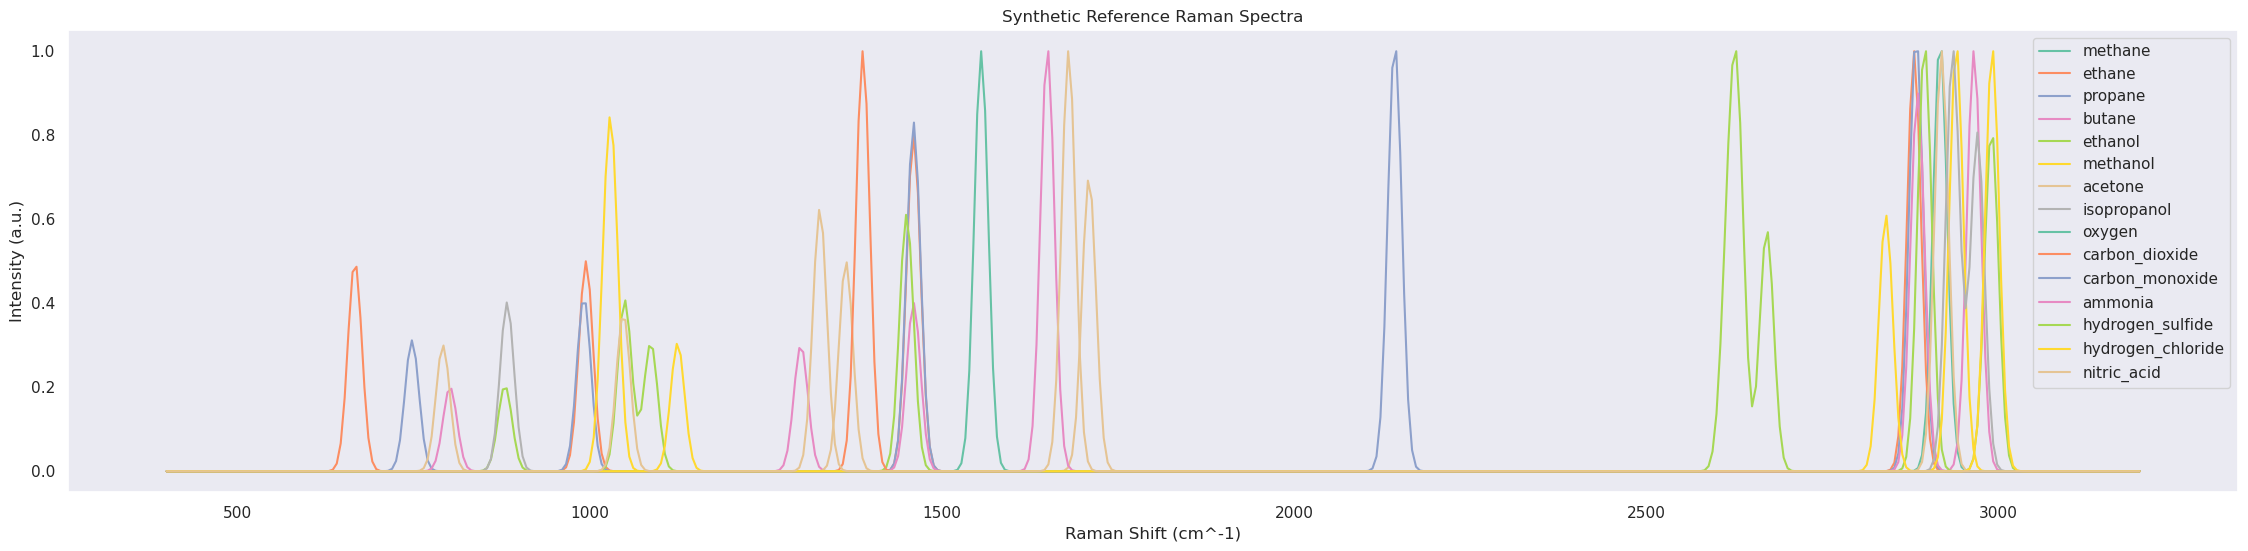

In [4]:
plt.figure(figsize=(28, 6))

# Precompute reference spectra for each compound
reference_spectra = {}
for compound, data in compound_library.items():
    ref_spectrum = generate_compound_spectrum(
        data["peak_positions"],
        data["peak_intensities"],
        wavenumbers,
        sigma=peak_width
    )
    reference_spectra[compound] = ref_spectrum

    plt.plot(wavenumbers, ref_spectrum, label=compound)
    
plt.xlabel("Raman Shift (cm^-1)")
plt.ylabel("Intensity (a.u.)")
plt.title(f"Synthetic Reference Raman Spectra")
plt.legend()
plt.show()
plt.close()

In [5]:
def generate_mixture_spectrum(compounds, concentrations, reference_spectra, noise_level=0.03):
    """
    Generate a synthetic mixture spectrum by linearly combining 
    the reference spectra according to the provided concentrations.
    """
    spectrum = np.zeros_like(wavenumbers)
    
    for compound, concentration in zip(compounds, concentrations):
        spectrum += concentration * reference_spectra[compound]
    # Add some noise
    noise = np.random.normal(0, noise_level, size=spectrum.shape)
    poly = ((0.00000005 * (wavenumbers)) ** 2) + 0.2 + np.random.normal(0, 0.05)
    return spectrum + noise + poly

In [6]:
# Let's create a dataset
n_samples = 100000  # number of training samples
compounds = list(compound_library.keys())
M = len(compounds)

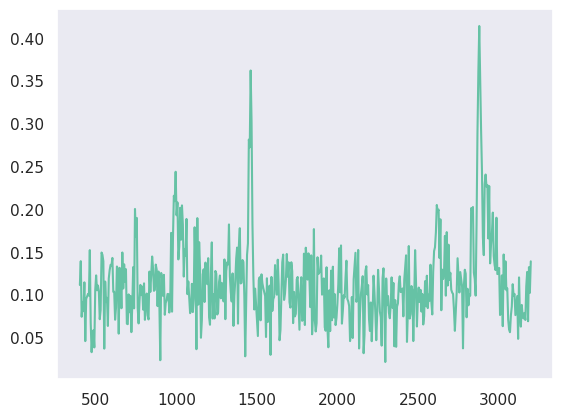

In [7]:
X_data = []
y_data = []

for _ in range(n_samples):
    # Generate random concentrations that sum to 1 (for simplicity).
    # In reality, you may allow them to be any set of random values.
    rand_concs = np.random.rand(M)
    rand_concs /= np.sum(rand_concs)  # normalize so sum=1

    for i in range(0, M):
        if np.random.rand() > 0.6:
            rand_concs[i] = 0
    
    # Get the synthetic mixture spectrum
    mixture_spectrum = generate_mixture_spectrum(compounds, rand_concs, reference_spectra)
    
    X_data.append(mixture_spectrum)
    y_data.append(rand_concs)

X_data = np.array(X_data)
y_data = np.array(y_data)

plt.plot(wavenumbers, X_data[0])
plt.show()
plt.close()

In [8]:
# Shuffle data
idx = np.random.permutation(n_samples)
X_data = normalize(X_data[idx])
y_data = y_data[idx]

In [9]:
# Train/test split
train_size = int(0.8 * n_samples)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [10]:
# Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train denoising autoencoder
autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(num_points,)),
    Dense(8, activation='relu'),
    Dense(2, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_points, activation='relu')
])

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder_history = autoencoder.fit(
    X_train, X_train,
    epochs=10, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

autoencoder.save('models/autoencoder.keras')

autoencoder.load_weights('models/autoencoder.keras')

/home/aniruth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-27 13:33:05.138904: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 8.8222e-04 - val_loss: 7.4643e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.0838e-04 - val_loss: 4.2398e-04
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.9769e-04 - val_loss: 3.6057e-04
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.6035e-04 - val_loss: 3.5693e-04
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.5722e-04 - val_loss: 3.5699e-04
Epoch 6/10
1338/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5708e-04

KeyboardInterrupt: 

In [ ]:
## Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build a TensorFlow Neural Network
regressor = Sequential([
    Dense(128, activation='relu', input_shape=(num_points,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(M, activation='linear')  # M outputs, one for each compound concentration
])

regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

#regressor.load_weights('models/v7.keras')

In [24]:
# Train the model
regressor_history = regressor.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

regressor.save('models/model.keras')

regressor.load_weights('models/model.keras')

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.2103e-04 - mae: 0.0129 - val_loss: 3.2985e-04 - val_mae: 0.0130
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.2115e-04 - mae: 0.0129 - val_loss: 3.2612e-04 - val_mae: 0.0130
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.1893e-04 - mae: 0.0129 - val_loss: 3.3856e-04 - val_mae: 0.0134
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.2055e-04 - mae: 0.0129 - val_loss: 3.3704e-04 - val_mae: 0.0130
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.2123e-04 - mae: 0.0129 - val_loss: 3.5301e-04 - val_mae: 0.0132
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.1730e-04 - mae: 0.0128 - val_loss: 3.1635e-04 - val_mae: 0.0128
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.1497e-04 - mae: 0.0128 - val_loss: 3.3866e-04 - val_mae: 0.0134
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.1697e-04 - mae: 0.0128 - val_loss: 3.354

Test MSE: 0.0003298476804047823, Test MAE: 0.013017749413847923
Train MSE: 0.0003198794147465378, Train MAE: 0.012853942811489105
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
0.000700484741884814


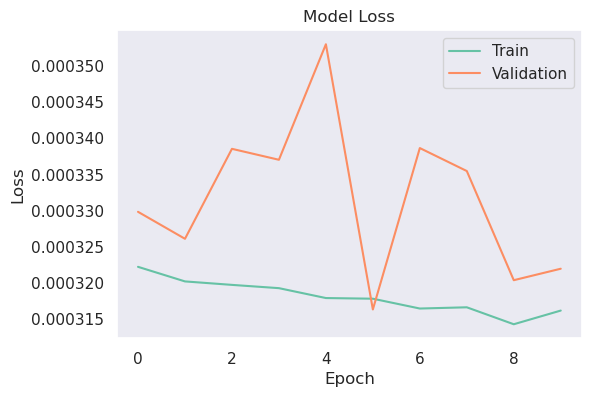

In [25]:
# Evaluate the Model
mse, mae = regressor.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {mse}, Test MAE: {mae}")

mse, mae = regressor.evaluate(X_train, y_train, verbose=0)
print(f"Train MSE: {mse}, Train MAE: {mae}")

print(np.abs(np.mean(regressor.predict(X_train) - y_train)))

plt.figure(figsize=(6, 4))
plt.plot(regressor_history.history['loss'])
plt.plot(regressor_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

MAE for Sample #6572 Concentrations : 0.0091


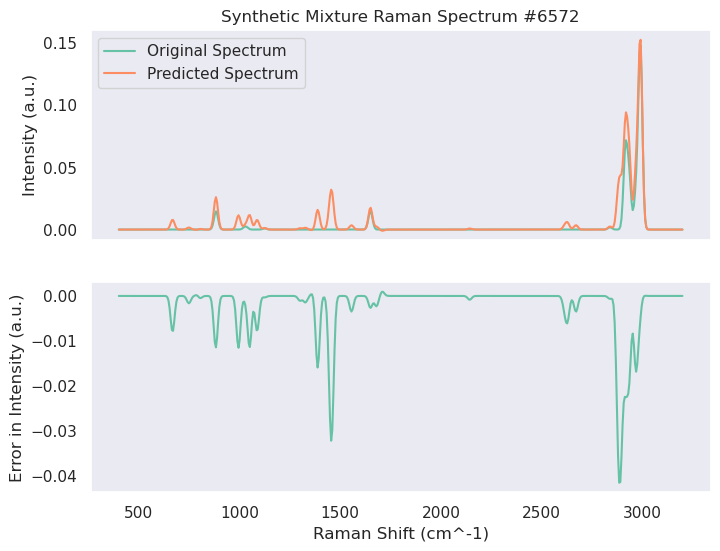

In [18]:
# Predict concentrations from the test set
X_denoised = autoencoder.predict(X_test, verbose=0)
predictions = regressor.predict(X_test, verbose=0)
idx_plot = np.random.randint(0, len(X_test))

original_spectrum = np.zeros_like(wavenumbers)
    
for compound, concentration in zip(compounds, y_test[idx_plot]):
    original_spectrum += concentration * reference_spectra[compound]

predicted_spectrum = np.zeros_like(wavenumbers)
    
for compound, concentration in zip(compounds, predictions[idx_plot].tolist()):
    predicted_spectrum += concentration * reference_spectra[compound]

import json

sample_mae = mean_absolute_error(predictions[idx_plot], y_test[idx_plot])
print(f"MAE for Sample #{idx_plot} Concentrations : {sample_mae:0.4f}")
#print(f"Predicted : {json.dumps(predictions[idx_plot].tolist(), indent=2)}")
#print(f"Actual    : {json.dumps(y_test[idx_plot].tolist(), indent=2)}")
#print(f"Error : {json.dumps(np.abs(predictions[idx_plot] - y_test[idx_plot]).tolist(), indent=2)}")

# Plot with seaborn
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
#plt.plot(wavenumbers, (X_test[idx_plot]) + np.abs(np.min(X_test[idx_plot])), label='Noisy Spectrum')
ax1.plot(wavenumbers, original_spectrum, label='Original Spectrum')
#plt.plot(wavenumbers, X_denoised[idx_plot], label='Autoencoder Denoised Spectrum')
ax1.plot(wavenumbers, predicted_spectrum, label='Predicted Spectrum')
ax2.plot(wavenumbers, original_spectrum - predicted_spectrum, label='Spectrum Error')
ax2.set_xlabel("Raman Shift (cm^-1)")
ax1.set_ylabel("Intensity (a.u.)")
ax2.set_ylabel("Error in Intensity (a.u.)")
ax1.set_title(f"Synthetic Mixture Raman Spectrum #{idx_plot}")
ax1.legend()

In [14]:
from sklearn.linear_model import LinearRegression

# CLS model (Linear Regression)
cls_model = LinearRegression()
cls_model.fit(X_train, y_train)
cls_coef = cls_model.coef_
cls_intercept = cls_model.intercept_
cls_model.score(X_test, y_test)

0.758880206927995

In [16]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(n_estimators=10, random_state=42, verbose=1)
random_forest_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Predict concentrations
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

In [21]:
y_pred = cls_model.predict(X_train)
print(f"Train MSE: {np.mean((y_pred - y_train) ** 2)}")
print(f"Train MAE: {np.abs(np.mean((y_pred - y_train)))}")
y_pred = cls_model.predict(X_test)
print(f"Test MSE: {np.mean((y_pred - y_test) ** 2)}")
print(f"Test MAE: {np.abs(np.mean((y_pred - y_test)))}")

Train MSE: 0.00045564573744708893
Train MAE: 4.212038125691227e-17
Test MSE: 0.0004714646854549007
Test MAE: 2.5578719304253362e-05


In [27]:
import time
import tracemalloc

def load_stats(func):
    def _inner(*args, **kwargs):
        print(func.__name__)
        start = time.time()
        tracemalloc.start()
        res = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        print(f"Executed in {time.time() - start:.4f} seconds")
        #print(f"Current memory usage: {current / 1024:.2f} KiB")
        print(f"Peak memory usage: {peak / 1024:.2f} KiB")
        print(f"Function output: {res}")

    return _inner

test_model = Sequential([
        Dense(128, activation='relu', input_shape=(num_points,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(M, activation='linear')  # M outputs, one for each compound concentration
    ])

test_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
test_model.load_weights('models/model.keras')

@load_stats
def test_SPARCSNet():
    mse, mae = test_model.evaluate(X_data, y_data, verbose=0)

    return mse, mae

@load_stats
def test_CLS():
    y_pred = cls_model.predict(X_data[:2000])
    return np.mean((y_pred - y_data[:2000]) ** 2)

@load_stats
def test_forest():
    y_pred = random_forest_model.predict(X_data)
    return  np.mean((y_test - y_data) ** 2)

test_SPARCSNet()
test_CLS()
#test_forest()

/home/aniruth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/aniruth/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


test_SPARCSNet
Executed in 6.3352 seconds
Peak memory usage: 403526.18 KiB
Function output: (0.0003218727943021804, 0.012886691838502884)
test_CLS
Executed in 0.0047 seconds
Peak memory usage: 704.43 KiB
Function output: 0.0004572501639788633
